# Helm charts security posture

Source data acquired from Artifact Hub, and analyzed using using [psa-checker](https://github.com/vicenteherrera/psa-checker), [BadRobot](https://github.com/controlplaneio/badrobot)

## Setup

Import required libraries

In [125]:
import yaml
import os
import re
from string import ascii_lowercase
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, display, Markdown
import tabulate

Define utility functions for increasing a key in a dict and a function to plot a donut diagram

In [104]:
def inc_dict(the_dict, the_key):
    the_dict[the_key] = 1 if the_key not in the_dict else the_dict[the_key] + 1
    return the_dict

def plot_donut(title, data, startatangle=-120):
    
    total = sum(data.values())
    title += (" (total " +str(total)+")")
    def per(x): return " (" + str ( round(100 * x / total, 2 )) + "%)"
    text = [(k + ": " + str(v) + per(v)) for k, v in data.items()]
    data = [(v) for _, v in data.items()]
    fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

    wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=startatangle)

    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
            bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(text[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.64*y),
                    horizontalalignment=horizontalalignment, **kw)

    ax.set_title(title)

    plt.show()

Load the data from disk, this can take a minute.

Take into consideration that all templates where statically generated without a cluster, and without providing any parameter to do so. Rendering them differently can produce completely different objects depending on if-else clauses in the chart.

In [105]:
charts_db = yaml.safe_load(open("data/charts_db_anon.yaml", 'r'))

## Downloaded, generated and error in charts

Of the total number of charts, how may we could download and generate a chart. If the generation of the chart fails, it may be because there are required parameters we are not specifying, or there is an error in the template. Those cases may generate incomplete templates, but those were not evaluated.

In [106]:
charts_count = {
        "error_download":0,
        "error_template":0,
        "generated": 0
    }
charts_generated = []
for chart in charts_db:
    l = chart["status"]["cache"]
    if l=="generated": charts_generated.append(chart)
    charts_count[l] = (charts_count[l]+1) if l in charts_count else 1
charts_count["total"] = len(charts_db)
print(tabulate.tabulate([(k, v) for k, v in charts_count.items()], headers=["type", "count"]))

type              count
--------------  -------
error_download      408
error_template     1171
generated          7699
total              9278


## Content, charts that create pods

Among generated charts, let's see how many include pod templates like deployments, daemonset, etc (includes_pods), how many include deployments v1beta1 for which PSS evaluation is not defined (version_not_evaluable), how many don't include any pod template at all but CRD that could generate one (no_pod_object_but_crd), and how many have neither pod nor CRD but can include configmaps, roles, etc (no_pod_object), and how many are completely empty (empty_no_object).

In [107]:
from copy import deepcopy

state_count = {
    'includes_pods': 0,
    'version_not_evaluable': 0,
    'no_pod_object_but_crd': 0,
    'no_pod_object': 0,
    'empty_no_object': 0,
}
for chart in charts_generated:
    l = chart["tools"]["pss"]["data"]["level"]
    if l in state_count.keys(): state_count[l] += 1
    else: state_count["includes_pods"] += 1

state_count_wt = deepcopy(state_count)
state_count_wt["total"] = len(charts_generated) 

print(tabulate.tabulate([(k, v) for k, v in state_count_wt.items()], headers=["type", "count"]))

type                     count
---------------------  -------
includes_pods             5627
version_not_evaluable      519
no_pod_object_but_crd     1340
no_pod_object              191
empty_no_object             22
total                     7699


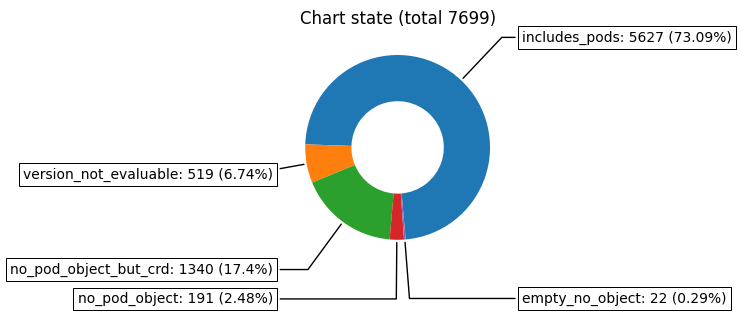

In [108]:
plot_donut("Chart state", state_count, -85)

# Pod Security Standards: psa-checker

Among generated charts that includes pods in a way that can be evaluated, let's see which Pod Security Standard level they comply with.

In [109]:
pss_count = {
        "privileged":0,
        "baseline":0,
        "restricted":0,
    }
for chart in charts_generated:
    l = chart["tools"]["pss"]["data"]["level"]
    if l in pss_count.keys(): pss_count[l] +=1

pss_count_wt = deepcopy(pss_count)
pss_count_wt["total"] = sum(pss_count.values())
print(tabulate.tabulate([(k, v) for k, v in pss_count_wt.items()], headers=["level", "count"]))

level         count
----------  -------
privileged      779
baseline       4806
restricted       42
total          5627


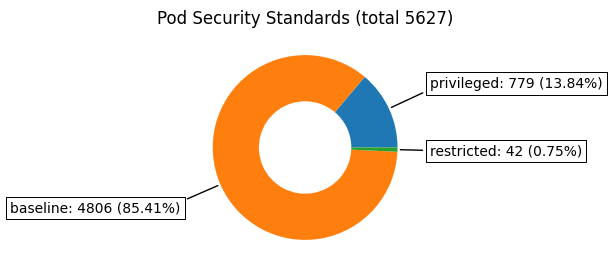

In [110]:
plot_donut("Pod Security Standards", pss_count, 0)

We see a mayority of charts in the baseline, which would be expected, some in privileged, and a few in retricted mode as it's extra work and people still don't acknowledge what they have to do to achieve this level.
Take into consideration that we are excluding here charts that we were unable to completely understand their security posture.

## Operators: BadRobot

Let's check BadRobot evaluation. It's rules are designed for operators, but we apply it to all generated charts no matter if they provide an operator or not. It outputs several discoveries with a score that is 0 or negative number (the closer to 0 the better). We sum all scores for a single chart. Some of the charts have an empty score (empty string) that we discard.

In [111]:
br_scores=[]
br_nonumbers=[]
for dic_chart in charts_generated:
    if "data" in dic_chart["tools"]["badrobot"]:
        score = dic_chart["tools"]["badrobot"]["data"]["score"]
        try:
            score=int(score)
            br_scores.append( score )
        except:
            br_nonumbers.append( score )

Data is very sparse, we use an histogram to represent it

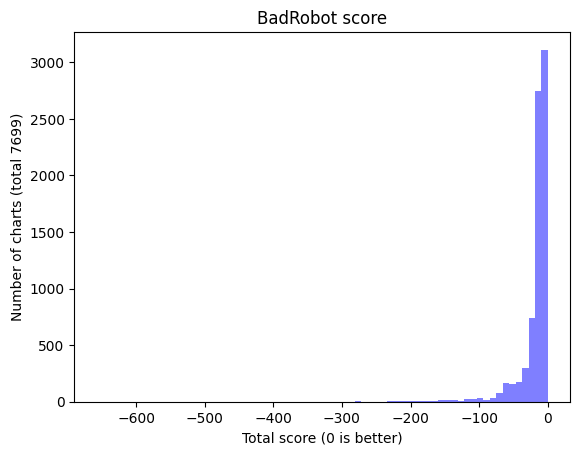

In [112]:
plt.hist(br_scores, 70,
         density=False,
         histtype='bar',
         facecolor='b',
         alpha=0.5)
plt.title('BadRobot score')
plt.xlabel('Total score (0 is better)')
plt.ylabel('Number of charts (total '+ str(len(charts_generated)) + ')' )
plt.show()

Most of the charts concentrate near the 0 score, which is a good thing.
Some bad charts live very far away from the 0 score, which means that not only they include bad practices, but at the same time, a lot of objects that don't comply with them.

## Container images

In [121]:
img_latest_count=0
img_known_count = {
    "busybox": 0,
    "curl": 0,
    "debian": 0,
    "bash": 0,
    "kubectl": 0
}
images_nolbl_count = {}
images_noreg_count = {}
images_count = {}
registries = {}
for chart in charts_generated:
    imgs = chart["tools"]["images"]["data"]
    for img in imgs:
        for k in img_known_count.keys():
            if k in img: 
                img_known_count[k] += 1
                break
        parts = img.split(":")
        inc_dict(images_count, img)
        inc_dict(images_nolbl_count, parts[0])
        if len(parts) == 1 or parts[1] == "latest": img_latest_count += 1
        parts2 = parts[0].split("/")
        inc_dict(images_noreg_count, parts2[-1])
        if len(parts2)==1 or "." not in parts2[0]: inc_dict(registries, "docker.io")
        else: inc_dict(registries, parts2[0])

img_total = sum(images_count.values())
img_known_count["other"] = img_total - sum(img_known_count.values())

img_known_count_wt = deepcopy(img_known_count)
img_known_count_wt["total"] = img_total
print(tabulate.tabulate([(k, v) for k, v in img_known_count_wt.items()], headers=["image contains", "count"]))

image contains      count
----------------  -------
busybox                63
curl                    5
debian                151
bash                    2
kubectl                18
other                3163
total                3402


For this list we take into consideration if the container image name includes a word, like busybox, curl, bash, kubectl or debian, in any place. We haven't considered names like docker or alpine, as they may be included for several other different reasons that may not be representative. 
A small number of charts use very generic container images, it's not even worth representing graphically. But it's not zero, and there will be many other generic images we are not counting here.

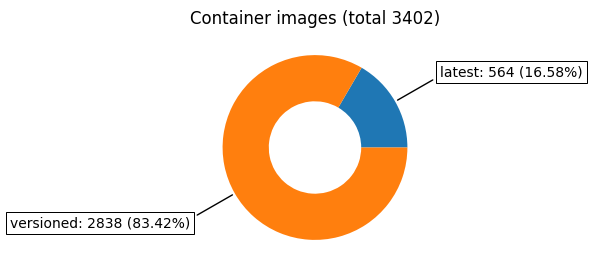

In [114]:
plot_donut("Container images", {"latest": img_latest_count, "versioned" : img_total - img_latest_count}, 0)

A surprising high number of images doesn't specify version or directly point to "latest" (which is the same)

Let's list the top 20 container images more used in general.  
An empty string, a signle whitespace character, or "null" may mean a required parameter has not been specified, but it didn't break the chart generation process.  
Here we consider the full image name and version.

In [115]:
images_count_sorted_list = list(images_count.items())
images_count_sorted_list.sort(key=lambda image: image[1], reverse=True)
images_count_sorted_list[:20]

print(tabulate.tabulate([(k, v) for k, v in images_count_sorted_list[:20]], headers=["image", "count"]))

image                                                             count
--------------------------------------------------------------  -------
image: null                                                          44
busybox                                                              29
gcr.io/kubebuilder/kube-rbac-proxy:v0.8.0                            14
busybox:latest                                                       12
                                                                     11
docker.io/openverso/open5gs:2.4.11                                   11
jenkins/jenkins:lts                                                  10
<registry>/orc8r_base:latest                                         10
alpine                                                                7
docker.io/bitnami/postgresql:11.10.0-debian-10-r9                     7
docker.io/tremolosecurity/kubernetes-artifact-deployment:1.1.0        7
docker.io/bitnami/mariadb:10.6.11-debian-11-r0                  

Same top 20, but not considering the version

In [116]:
images_nolbl_count_sorted_list = list(images_nolbl_count.items())
images_nolbl_count_sorted_list.sort(key=lambda image: image[1], reverse=True)

print(tabulate.tabulate([(k, v) for k, v in images_nolbl_count_sorted_list[:20]], headers=["image", "count"]))

image                                                  count
---------------------------------------------------  -------
busybox                                                   58
image                                                     44
nginx                                                     40
gcr.io/kubebuilder/kube-rbac-proxy                        27
alpine                                                    18
docker.io/bitnami/postgresql                              17
                                                          11
docker.io/openverso/open5gs                               11
jenkins/jenkins                                           10
<registry>/orc8r_base                                     10
postgres                                                   9
docker.io/bitnami/nginx                                    9
registry                                                   9
traefik                                                    8
                        

In [117]:
images_noreg_count_list = list(images_noreg_count.items())
images_noreg_count_list.sort(key=lambda image: image[1], reverse=True)
images_noreg_count_list[:25]

print(tabulate.tabulate([(k, v) for k, v in images_noreg_count_list[:25]], headers=["image", "count"]))

image                 count
------------------  -------
busybox                  63
nginx                    57
image                    46
kube-rbac-proxy          29
postgresql               22
alpine                   21
mariadb                  18
minio                    16
jenkins                  15
kubectl                  14
server                   14
mysql                    14
                         11
                         11
operator                 11
open5gs                  11
postgres                 10
kube-state-metrics       10
gitlab-runner            10
registry                 10
orc8r_base               10
nfs-provisioner           9
redis                     9
traefik                   8
mysqld-exporter           8


Let's check which are the more popular registries

In [122]:
registries_list = list(registries.items())
registries_list.sort(key=lambda image: image[1], reverse=True)
print(tabulate.tabulate([(k, v) for k, v in registries_list[:25]], headers=["image", "count"]))

image                                           count
--------------------------------------------  -------
docker.io                                        2285
ghcr.io                                           394
quay.io                                           210
gcr.io                                             97
marketplace.azurecr.io                             49
k8s.gcr.io                                         40
registry.cn-beijing.aliyuncs.com                   39
registry.cn-shanghai.aliyuncs.com                  29
public.ecr.aws                                     24
registry.cn-hangzhou.aliyuncs.com                  24
registry.gitlab.com                                21
docker-registry.wikimedia.org                      16
docker.elastic.co                                  14
registry.opensource.zalan.do                       11
gitlab-registry.cern.ch                            11
us.gcr.io                                          10
index.docker.io             

Let's search if some specific images are included, and how many times

In [127]:
p = re.compile('^.*xmrig.*$')
found = [ s for s in images_count.keys() if p.match(s) ]
found

['brannondorsey/alpine-xmrig:v5.8.2']

Relax, it's the one for the official XMRig helm chart, not a cryptominer injection.  

What about include "miner" in the name?

In [128]:
p = re.compile('^.*miner.*$')
found = [ s for s in images_count.keys() if p.match(s) ]
found

['adminer:4.8.1-standalone', 'dockette/adminer:latest']

Nothing out of the ordinary